In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pymc3 as pm
import theano
import numpy as np

np.random.seed(42)
pm.set_tt_rng(42)

In [82]:
w = pm.floatX([.2, .8])
mu = pm.floatX([-.3, .5])
sd = pm.floatX([.1, .1])

with pm.Model() as model:
    # there is no data here, just a model we can sample from (a mixture)
    x = pm.NormalMixture('x', w=w, mu=mu, sigma=sd, dtype=theano.config.floatX)
    x2 = x ** 2
    sin_x = pm.math.sin(x)

    # if we want to see traces of other quantities, wrap them in Deterministics
    pm.Deterministic('x2', x2) # do this to save samples of the expressions
    pm.Deterministic('sin_x', sin_x)

    trace = pm.sample(50000, chains=4) #,return_inferencedata=True)

    # return_inferencedata changes the return type. Is either arviz.InferenceData
    # or MultiTrace

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [x]


In [18]:
trace.posterior["x"].shape

(4, 50000)

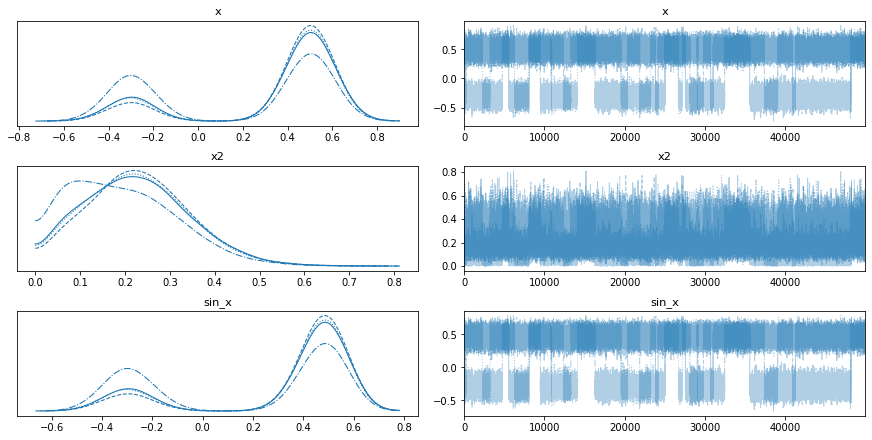

In [19]:
pm.traceplot(trace);

The variational inference approach is different. We get inference from model, then calculate expressions later.

In [20]:
with pm.Model() as model:
    x = pm.NormalMixture("x", w=w, mu=mu, sigma=sd, dtype=theano.config.floatX)
    x2 = x ** 2 # try with Deterministic
    sin_x = pm.math.sin(x)

    # use ADVI
    mean_field = pm.fit(method="advi")

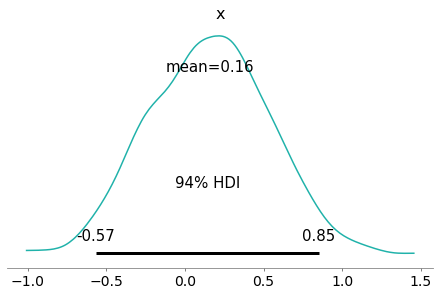

In [21]:
pm.plot_posterior(mean_field.sample(1000), color="LightSeaGreen");

Did it converge?

In [22]:
help(pm.callbacks.CheckParametersConvergence)

Help on class CheckParametersConvergence in module pymc3.variational.callbacks:

class CheckParametersConvergence(Callback)
 |  CheckParametersConvergence(every=100, tolerance=0.001, diff='relative', ord=inf)
 |  
 |  Convergence stopping check
 |  
 |  Parameters
 |  ----------
 |  every: int
 |      check frequency
 |  tolerance: float
 |      if diff norm < tolerance: break
 |  diff: str
 |      difference type one of {'absolute', 'relative'}
 |  ord: {non-zero int, inf, -inf, 'fro', 'nuc'}, optional
 |      see more info in :func:`numpy.linalg.norm`
 |  
 |  Examples
 |  --------
 |  >>> with model:
 |  ...     approx = pm.fit(
 |  ...         n=10000, callbacks=[
 |  ...             CheckParametersConvergence(
 |  ...                 every=50, diff='absolute',
 |  ...                 tolerance=1e-4)
 |  ...         ]
 |  ...     )
 |  
 |  Method resolution order:
 |      CheckParametersConvergence
 |      Callback
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __

In [24]:
with model:
    mean_field = pm.fit(method="advi",
        callbacks=[pm.variational.callbacks.CheckParametersConvergence()])

Look at the fitting (inference) history via the `.hist` attribute.

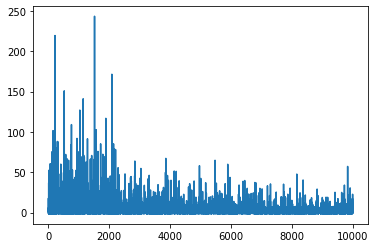

In [27]:
plt.plot(mean_field.hist);

In [28]:
with model:
    mean_field = pm.fit(method="advi",
        callbacks=[pm.variational.callbacks.CheckParametersConvergence(diff="absolute")])

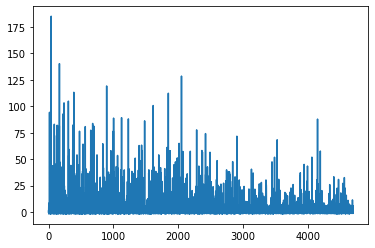

In [29]:
plt.plot(mean_field.hist);

We can also directly track parameters. There is an object-oriented API which makes inference easier.

In [30]:
with model:
    advi = pm.ADVI()

advi.approx

In [33]:
advi.approx.shared_params # hyperparameters of the variational family

{'mu': mu, 'rho': rho}

In [36]:
advi.approx.mean.eval(), advi.approx.std.eval() # shortcuts to some statistics assoc. with the approx

(array([0.34]), array([0.69314718]))

In [37]:
# use the Tracker callback to keep track of these
# ?pm.callbacks.Tracker
tracker = pm.callbacks.Tracker(
    mean=advi.approx.mean.eval,
    std=advi.approx.std.eval,
)

In [38]:
approx = advi.fit(20000, callbacks=[tracker])

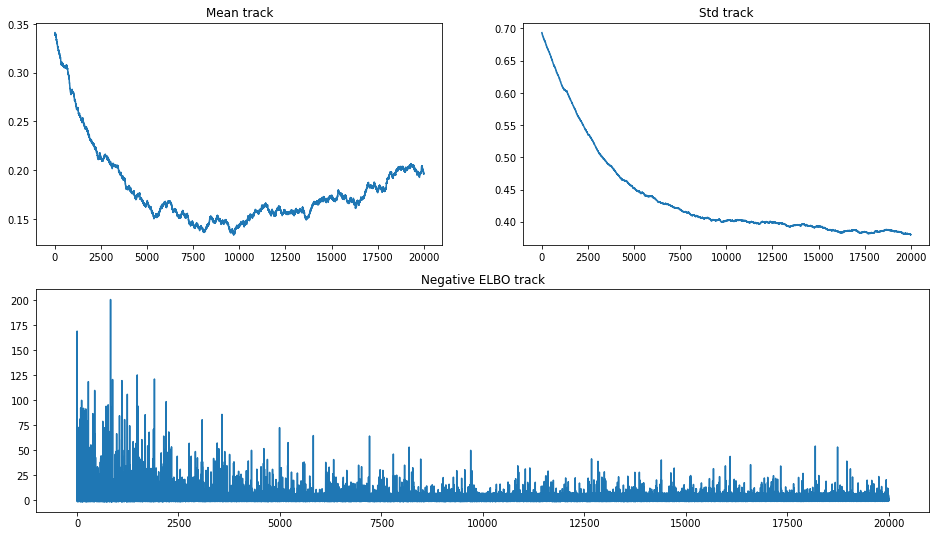

In [51]:
len(tracker["mean"])

fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker['mean'])
mu_ax.set_title('Mean track')
std_ax.plot(tracker['std'])
std_ax.set_title('Std track')
hist_ax.plot(advi.hist)
hist_ax.set_title('Negative ELBO track');

Looks like the mean did not entirely converge. Let's continue running the approximation.

In [52]:
advi.refine(100000)

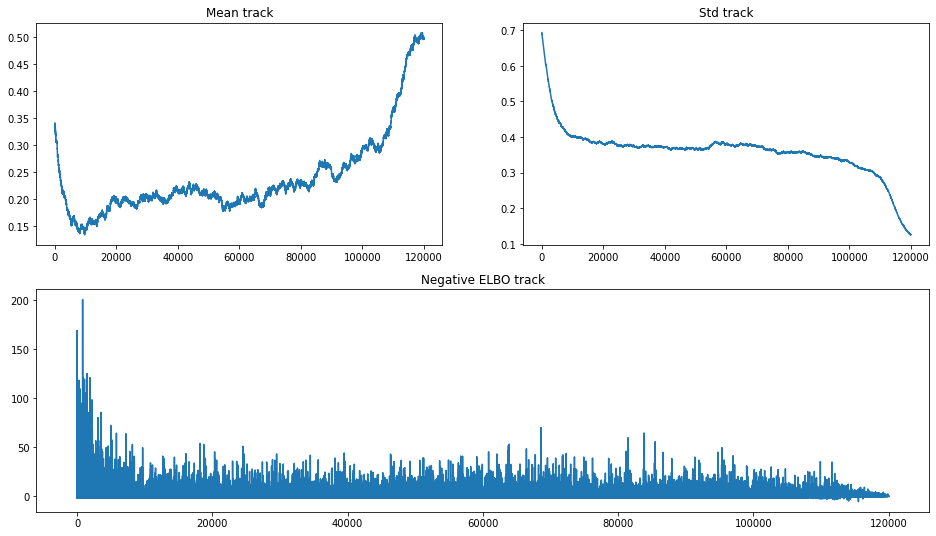

In [53]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker['mean'])
mu_ax.set_title('Mean track')
std_ax.plot(tracker['std'])
std_ax.set_title('Std track')
hist_ax.plot(advi.hist)
hist_ax.set_title('Negative ELBO track');

Still not good. Looks like a random walk in the mean. Maybe we should use a different inference algorithm.

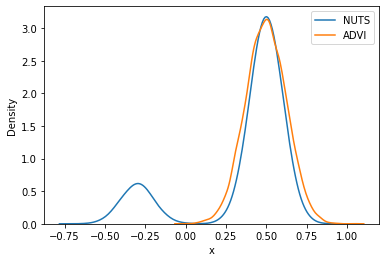

In [65]:
# compare with NUTS
import seaborn as sns
ax = sns.kdeplot(trace.posterior["x"][2,:], label="NUTS")
sns.kdeplot(approx.sample(10000)["x"], label="ADVI")
ax.legend()
plt.show()

Note that the ADVI is unable to handle the multimodal posterior. SVGD is another inference method which is particle-based.

In [66]:
with model:
    svgd_approx = pm.fit(300, method='svgd', inf_kwargs=dict(n_particles=1000),
        obj_optimizer=pm.sgd(learning_rate=0.01))

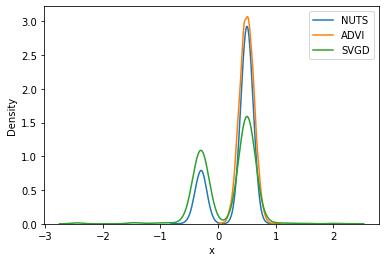

In [67]:
# compare with NUTS
import seaborn as sns
ax = sns.kdeplot(trace.posterior["x"][0,:], label="NUTS")
sns.kdeplot(approx.sample(10000)["x"], label="ADVI")
sns.kdeplot(svgd_approx.sample(2000)["x"], label="SVGD")
ax.legend()
plt.show()

It's better; still not perfect, but now it recognizes the multimodality.

Note:
* `advi` is mean-field variational inference
* alternative methods include `fullrank_advi`

In [69]:
# we can calc arbitrary functions
a = x**2
b = pm.math.sin(x)

In [72]:
# how to actuaally evaluate them?
help(svgd_approx.sample_node)

Help on method sample_node in module pymc3.variational.opvi:

sample_node(node, size=None, deterministic=False, more_replacements=None) method of pymc3.variational.approximations.Empirical instance
    Samples given node or nodes over shared posterior
    
    Parameters
    ----------
    node: Theano Variables (or Theano expressions)
    size: None or scalar
        number of samples
    more_replacements: `dict`
        add custom replacements to graph, e.g. change input source
    deterministic: bool
        whether to use zeros as initial distribution
        if True - zero initial point will produce constant latent variables
    
    Returns
    -------
    sampled node(s) with replacements



In [74]:
a_sample = svgd_approx.sample_node(a)
a_sample.eval()

array(0.05881954)

In [75]:
a_sample.eval()

array(0.08425792)

What are wwe drawing from, here? This is clearly stochastic, but what is going on?

At this point we have abstracted away from the original `PyMC3` model and now are only interested in the approximation (to the posterior).

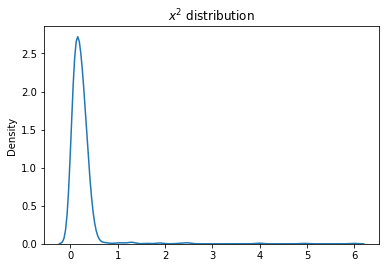

In [78]:
sns.kdeplot(np.array([a_sample.eval() for _ in range(2000)]));
plt.title('$x^2$ distribution');

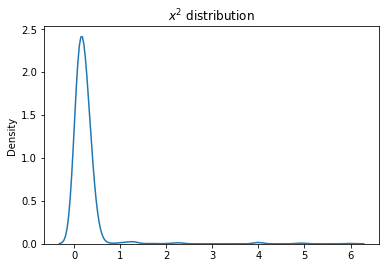

In [80]:
# easily get many samples at once from sample_node
a_samples = svgd_approx.sample_node(a, size=1000)
sns.kdeplot(a_samples.eval())
plt.title('$x^2$ distribution');

#### If we are given an MCMC trace...

we can convert it into an approximation 



In [81]:
trace_approx = pm.Empirical(trace, model=model)
trace_approx

AttributeError: 'InferenceData' object has no attribute 'varnames'

## Multilabel logistic regression

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import theano.tensor as tt 
import pandas as pd

X,y = load_iris(True)
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [5]:
Xt = theano.shared(X_train)
yt = theano.shared(y_train)

with pm.Model() as iris_model:
    # coeffs for features
    beta = pm.Normal("beta", 0, sigma=1e2, shape=(4,3)) # priors
    # transform to unit interval
    a = pm.Flat("a", shape=(3,))
    p = tt.nnet.softmax(Xt.dot(beta)+a) # logistic function (softmax); single layer NN

    observed = pm.Categorical('obs', p=p, observed=yt) # categorical distribution

The tutorial references latent variables here, saying that there are symbolic inputs for latent variables.
> To evaluate an espression that requires knowledge of latent variables, one needs to provide fixed values. We can use values approximated by VI for this purpose.

In [6]:
with iris_model:

    # use SVGD
    inference = pm.SVGD(n_particles=500, jitter=1)

    # local ref to approx
    approx = inference.approx

    # need `more_replacements` to change train_set to test_set
    # can use this arg in pm.fit as well
    test_probs = approx.sample_node(p, 
        more_replacements={Xt: X_test},
        size=100
        )

    # for train set, no more replacements needed
    train_probs = approx.sample_node(p)

We have sampled 100 probabilities for each observation. ???

In [7]:
# create symbolic expressions for sampled accuracy score
test_ok = tt.eq(test_probs.argmax(-1), y_test)
train_ok = tt.eq(train_probs.argmax(-1), y_train)
test_accuracy = test_ok.mean(-1)
train_accuracy = train_ok.mean(-1)

In [8]:
# calls are cached so they can be reused
eval_tracker = pm.callbacks.Tracker(
    test_accuracy=test_accuracy.eval,
    train_accuracy=train_accuracy.eval
)

In [9]:
inference.fit(100, callbacks=[eval_tracker])

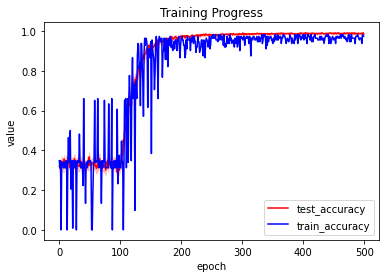

In [13]:
import seaborn as sns
_, ax = plt.subplots(1, 1)
df = pd.DataFrame(eval_tracker['test_accuracy']).T.melt()
sns.lineplot(x="variable", y="value", data=df, color='red', ax=ax)
ax.plot(eval_tracker['train_accuracy'], color='blue')
ax.set_xlabel('epoch')
plt.legend(['test_accuracy', 'train_accuracy'])
plt.title('Training Progress');

In [ ]:
inference.fit(400, obj_optimizer=pm.adamax(learning_rate=0.1), callbacks=[eval_tracker]);

In [ ]:
_, ax = plt.subplots(1, 1)
df = pd.DataFrame(np.asarray(eval_tracker['test_accuracy'])).T.melt()
sns.lineplot(x="variable", y="value", data=df, color='red', ax=ax)
ax.plot(eval_tracker['train_accuracy'], color='blue')
ax.set_xlabel('epoch')
plt.legend(['test_accuracy', 'train_accuracy'])
plt.title('Training Progress');